<a href="https://colab.research.google.com/github/alissonjcjk/Projeto-de-Machine-learning-MLP-/blob/main/Projeto_Machine_Learning(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini projeto MLP
  O objetivo é construir um modelo preditivo baseado em Multilayer Perceptron (MLP) para estimar a sobrevivência de passageiros do naufrágio do Titanic utilizando um banco de dados disponível na plaforma Kaggle.
Objetivos:
* Fazer uma EDA (Análise Exploratória dos Dados);
* Fazer divisão do dataset como indicado no pdf (50% para trinamento; 25% para validação; 25% para teste)
* Pré-processar/Tratar os dados, tornando-os adequados para o treinamento do modelo;
* Fazer o Oversampling da classe minoritária no conjunto de treinamento;
* Construir e Treinar Redes Neurais baseadas em MLP para previsão da sobrevivência ou não dos passageiros;
* Validar e avaliar o desempenho dos modelos propostos utilizando métricas diversas e a partir disso, fazer o ajuste dos hiper parâmetros;
* Identificado o melhor modelo, aplicá-lo ao conjunto de teste.


# Carregamento dos Dados

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic

!unzip -q titanic.zip

# Checa os arquivos carregados
!ls


Saving kaggle.json to kaggle.json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
gender_submission.csv  sample_data  test.csv  titanic.zip  train.csv


#Análise Exploratória dos Dados (EDA) - Conhecendo o DataSet
A ideia dessa etapa é identificar as features e seus tipos, além de criar alguns gráficos de visualizações que fornecer um maior conhecimento do comportamento e das características de algumas variáveis, como dados faltantes ou inconsistentes. Isso é crucial para a tomada de algumas decisões na etapa de tratamento de dados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

treinamento = pd.read_csv('train.csv')

# Olhando as dimensões do dataset (quantas linhas e colunas)
treinamento.shape

(891, 12)

In [ ]:
# Exibindo as primeiras linhas para ter uma visão inicial geral do dataset
treinamento.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:

# Ajuda a identificar que features têm valores Nulos
# Para futuro tratamento. No caso, Age; Cabin; Embarked
# Além de ajudar a descobrir os tipos das variáveis
treinamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Identifica as variáveis númericas, que serão tratadas
numeric_cols = treinamento.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)

# Identifica as variáveis Categóricas, que serão
# Convertidas/Codificadas em numéricas

categorical_cols = treinamento.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


#Separação entre as variáveis numéricas: Discretas ou Contínuas.

Útil, nesse trecho, para saber que tipo de gráfico usar; de barras para discretas e histogramas para contínuas.

Vale ainda ressaltar que Utilizou-se a regra de Freedman-Diaconis para determinar o número idealde "caixas"/bins do histograma.

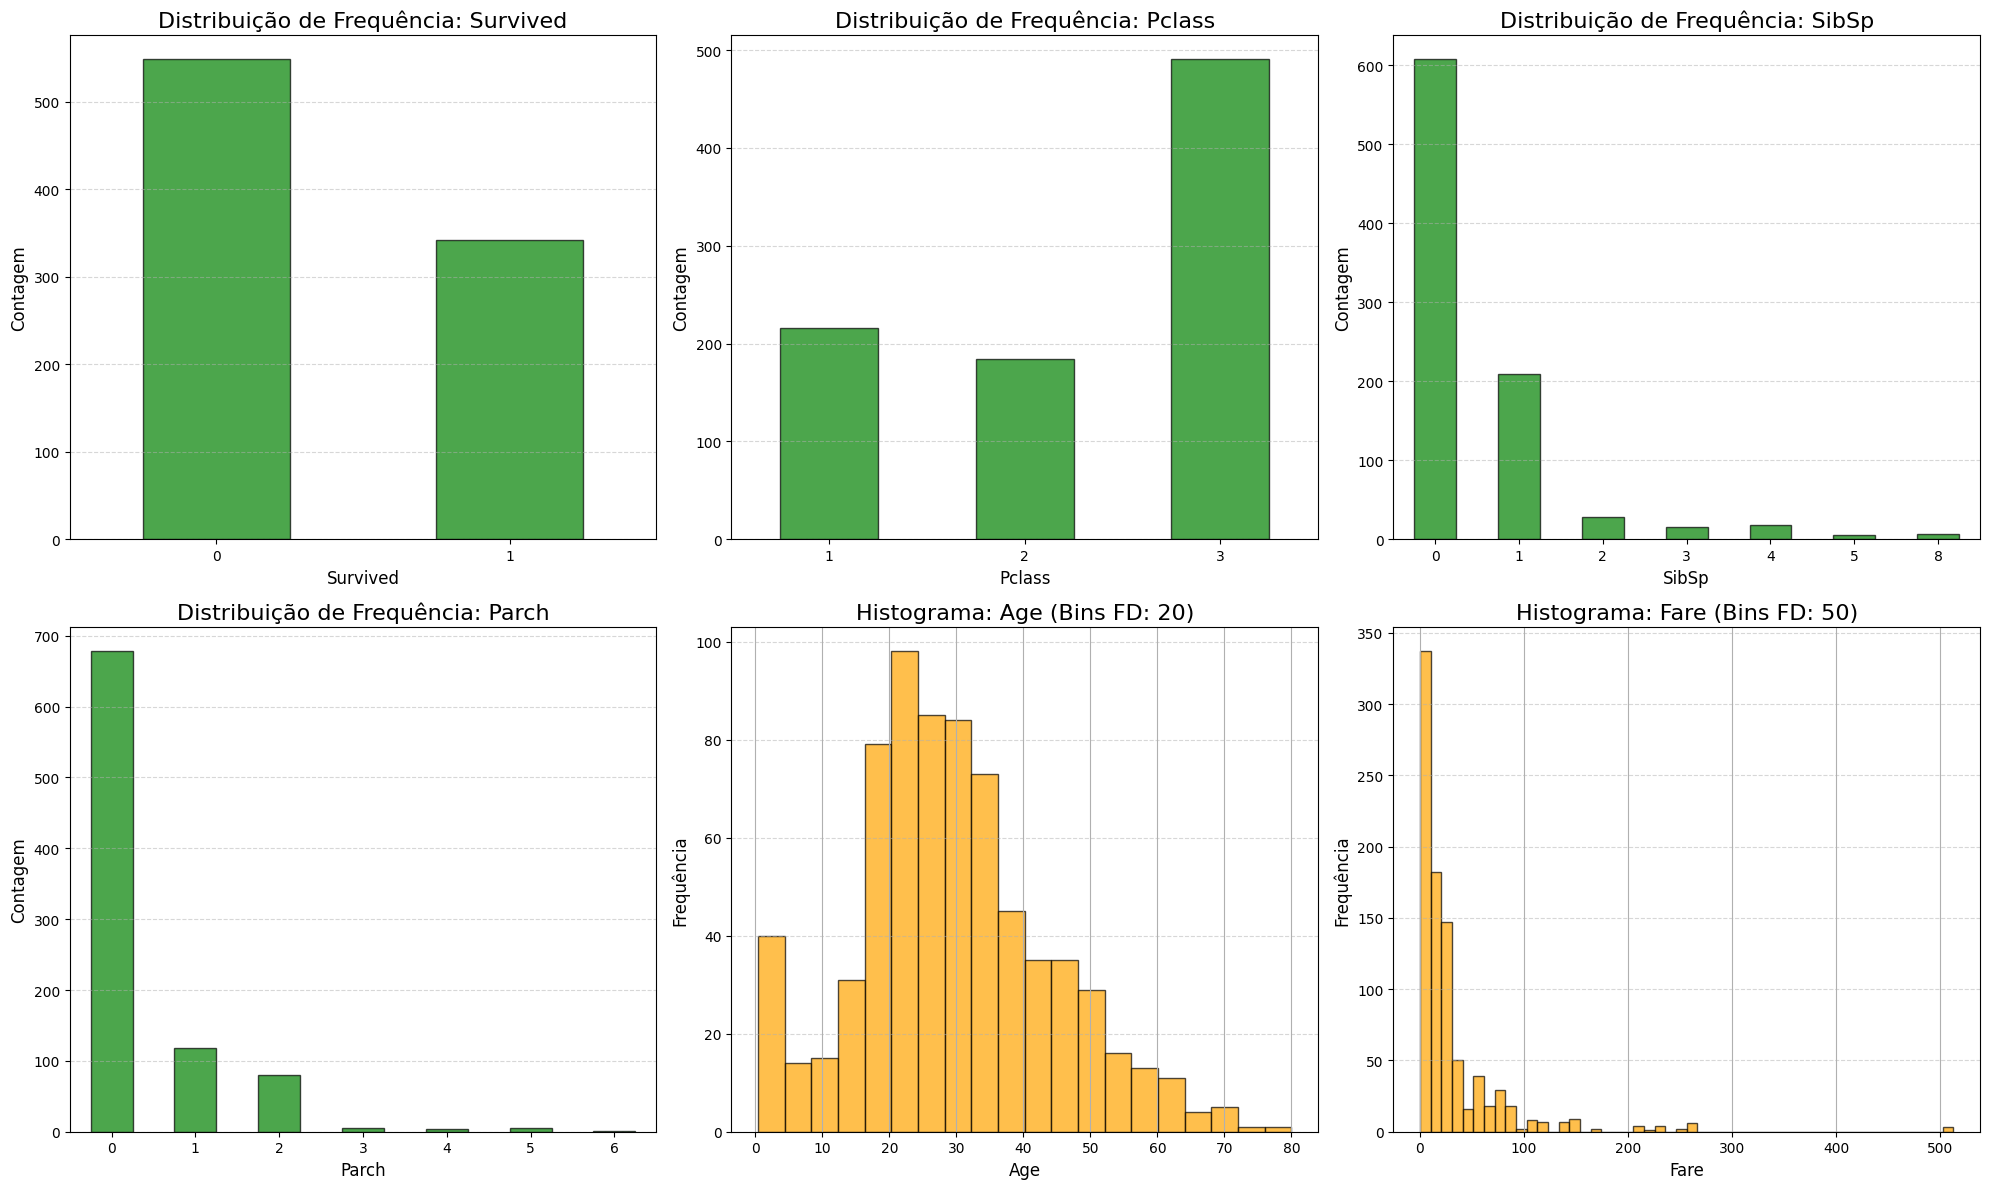

In [ ]:

# 1. Definição das colunas
# Variáveis Discretas/Binárias (Gráfico de Barras)
discrete_features = ['Survived', 'Pclass', 'SibSp', 'Parch']
# Variáveis Contínuas (Histograma)
continuous_features = ['Age', 'Fare']
# Observe que foi ignorada a coluna PassengerID na plotagem dos gráficos

# Configuração do layout de plotagem (2 linhas, 3 colunas)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

# Cores para visualização
discrete_color = 'green'
continuous_color = 'orange'

# 2. Plotagem de Features Discretas (Gráfico de Barras)
for i, col in enumerate(discrete_features):
    ax = axes[i]
    # Usa value_counts() para contagem de frequência de dados discretos
    treinamento[col].value_counts().sort_index().plot(kind='bar', ax=ax, color=discrete_color, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribuição de Frequência: {col}', fontsize=16)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Contagem', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=0)

# 3. Plotagem de Features Contínuas (Histogramas com Bins Freedman-Diaconis)
# Utilizou-se a regra de Freedman-Diaconis para determinar o número ideal
# de "caixas"/bins do histograma.
for i, col in enumerate(continuous_features):
    ax = axes[i + len(discrete_features)]

    # Seleciona dados não nulos para o cálculo (importante para 'Age')
    data = treinamento[col].dropna()
    n = len(data)

    # Cálculo do IQR para a Regra Freedman-Diaconis
    Q3, Q1 = np.percentile(data, [75 ,25])
    feature_iqr = Q3 - Q1

    if feature_iqr == 0 or n <= 1:
        # Caso de fallback para dados uniformes ou muito pequenos
        num_bins = 10
    else:
        # Largura do Bin (Bin Width) = 2 * IQR * n^(-1/3)
        bin_width = 2 * feature_iqr * (n ** (-1/3))
        # Número de Bins = (Máx - Mín) / Largura do Bin
        num_bins = int(np.ceil((data.max() - data.min()) / bin_width))
        # Garante um número mínimo de bins para visualização
        num_bins = max(5, min(50,num_bins)) # Colocou-se min de 50, pois
        # no Fare, passou de 100 bins, o que dificultou a visualização.

    # Plotagem do histograma
    treinamento[col].hist(bins=num_bins, ax=ax, color=continuous_color, edgecolor='black', alpha=0.7)
    ax.set_title(f'Histograma: {col} (Bins FD: {num_bins})', fontsize=16)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#Plotagem de gráficos para analisar a frequência de variáveis categóricas

Decidiu-se não plotar gráficos para as features 'Name'e 'Ticket' porque elas não agregam muito valor semântico, além de serem valores únicos por passageiro, logo, decidimos não visualizá-los

Já 'Cabin' tem muitos valores nulos, o que torna a distribuição dos valores
existentes pouco representativa ou útil sem um pré-tratamento. e também porque
seu valor é quase único por passageiro, sendo difícil de ser visualizado no gráfico

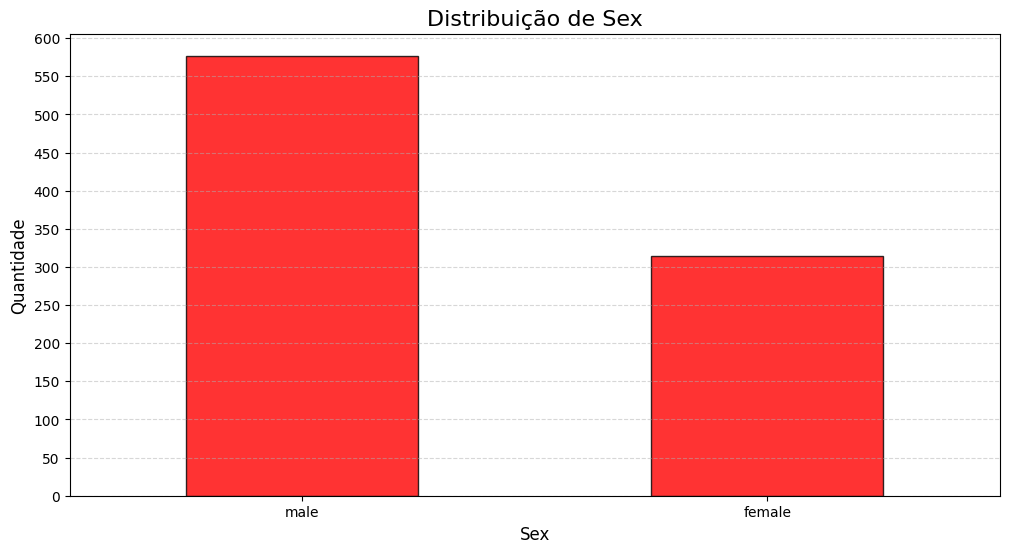

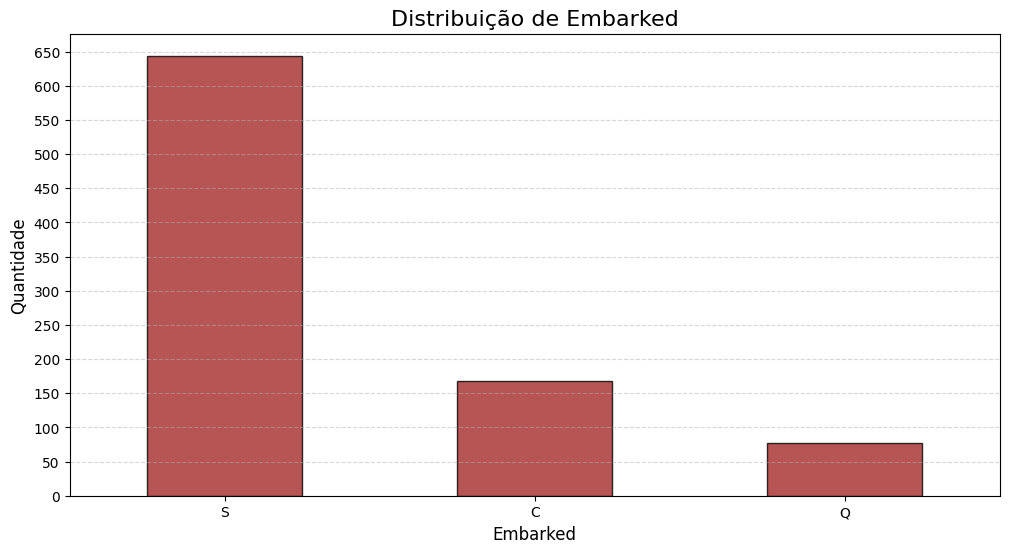

In [ ]:
# Variáveis categóricas
# Observe que 'Name'e 'Ticket' não agregam muito valor semântico,
# além de serem valores únicos por passageiro, logo, decidimos não visualizá-los

# Já 'Cabin' tem muitos valores nulos, o que torna a distribuição dos valores
# existentes pouco representativa ou útil sem um pré-tratamento, e também porque
# seu valor é quase único por passageiro, sendo difícil de ser visualizado no gráfico

categorical_features = ['Sex', 'Embarked']
colors = ['red', 'brown']

for col, color in zip(categorical_features, colors):
    plt.figure(figsize=(12, 6))
    counts = treinamento[col].value_counts()

    counts.plot(kind='bar', color=color, edgecolor='black', alpha=0.8)

    plt.title(f'Distribuição de {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Quantidade', fontsize=12)

    max_val = counts.max()
    plt.yticks(range(0, max_val + 50, 50))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    plt.show()





#Segue a plotagem de algumas aglumas variáveis juntamente com a de survived para uma prévia análise de correlação (apenas algo intuitivo/geral)

Percebeu-se uma tendência de sobrevivência em pessoas do sexo feminino e em pessoas mais ricas; e, possivelmente, de forma proprocional, em pessoas cujo portão de embarque foi o C

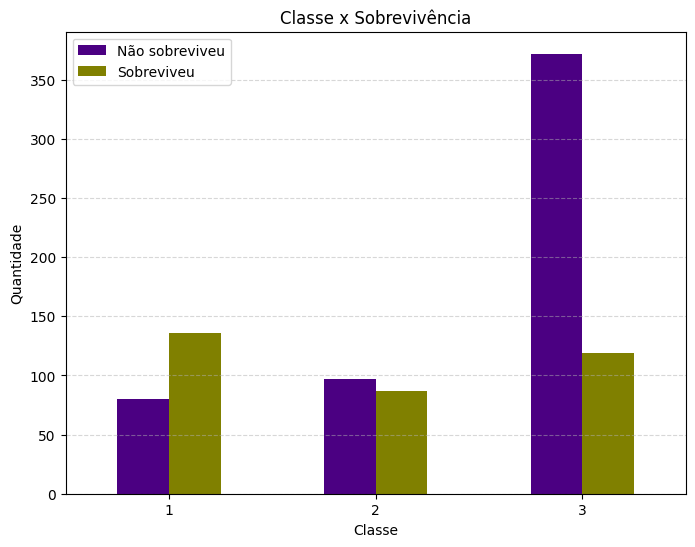

In [ ]:
table = pd.crosstab(index=treinamento['Pclass'], columns=treinamento['Survived'])

table.columns = ['Não sobreviveu', 'Sobreviveu']

table.plot(kind='bar', figsize=(8,6), color= ['indigo','olive'])

plt.title('Classe x Sobrevivência')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

plt.show()

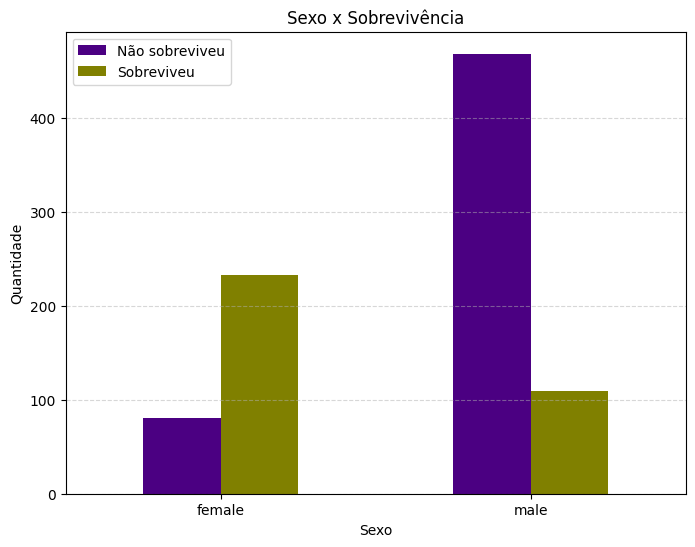

In [ ]:
table = pd.crosstab(index=treinamento['Sex'], columns=treinamento['Survived'])

table.columns = ['Não sobreviveu', 'Sobreviveu']

table.plot(kind='bar', figsize=(8,6), color= ['indigo','olive'])

plt.title('Sexo x Sobrevivência')
plt.xlabel('Sexo')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

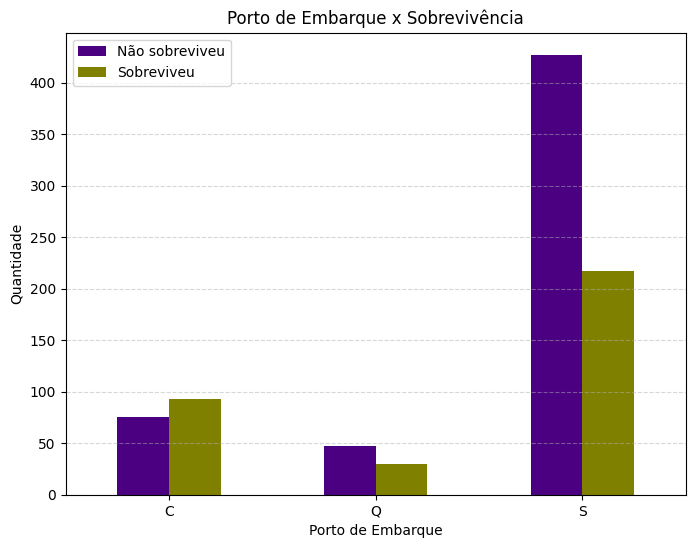

In [ ]:
table = pd.crosstab(index=treinamento['Embarked'], columns=treinamento['Survived'])

table.columns = ['Não sobreviveu', 'Sobreviveu']

table.plot(kind='bar', figsize=(8,6), color= ['indigo','olive'])

plt.title('Porto de Embarque x Sobrevivência')
plt.xlabel('Porto de Embarque')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

#Segue um heatmap para identificar possíveis correlações entre variáveis

Identificou-se uma corrleção moderada entre as features SibSp e Parch, de 0.41 e também pela definição de ambas, faz sentido juntá-las em uma única variável que conta a quantidade de familiares a bordo do navio.

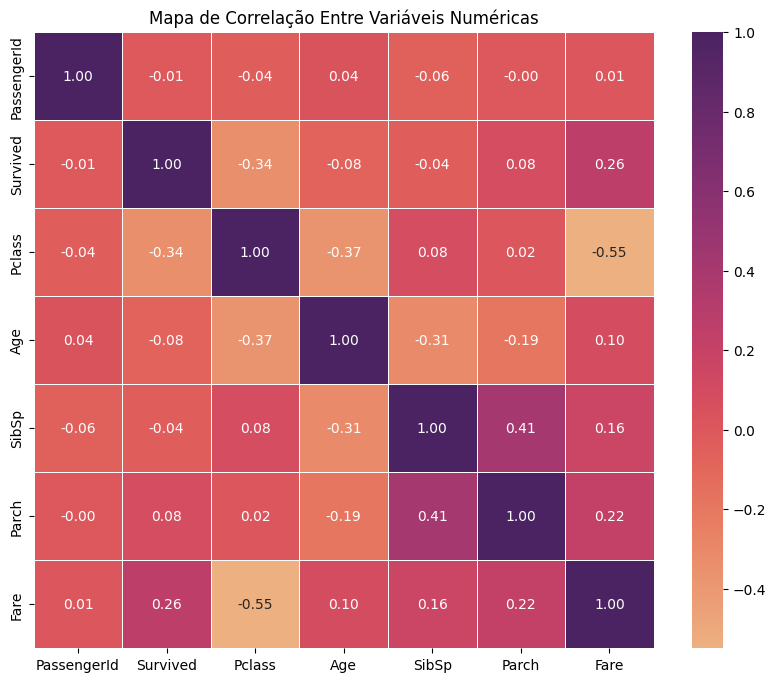

In [ ]:
numeric_df = treinamento.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='flare', linewidths=0.5, fmt=".2f")

plt.title('Mapa de Correlação Entre Variáveis Numéricas')
plt.show()

# A conclusão do heatmap foi a de que se chegou foi que as features SibSp e Parch são bem correlacionadas (0.41) e
# também pela definição de ambas, faz sentido juntá-las em uma única variável que conta a quantidade de familiares a bordo do navio.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


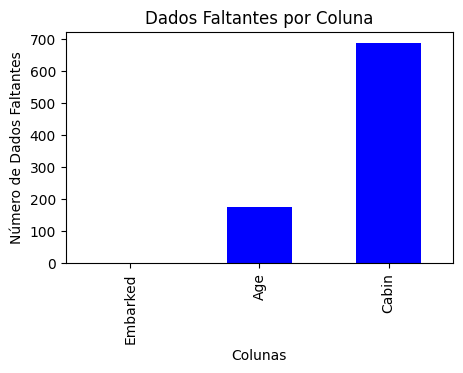

In [ ]:
# Visualizando melhor os dados faltantes

faltando = treinamento.isnull().sum()
print(faltando)

faltando = faltando[faltando > 0]
faltando.sort_values(inplace=True)

faltando.plot.bar(color='b', figsize=(5, 3))
plt.xlabel('Colunas')
plt.ylabel('Número de Dados Faltantes')
plt.title('Dados Faltantes por Coluna')

plt.show()

#Segue Divisão dos dados em conjuntos de treinamento, validação e teste

O algoritmo usado foi:
* Separou-se os dados em 2 classes: quem morreu e quem sobreviveu
* De cada classe, sorteou-se 50% para treinamento, 25% para validaçaõ e 25% para teste
* Combinou-se os conjuntos correspondetes de cada classe para formar os conjuntos "finais" e reembaralhou-se os dados

In [ ]:
from sklearn.utils import resample

# Separar as classes
classe_morreu = treinamento[treinamento['Survived'] == 0]
classe_sobreviveu = treinamento[treinamento['Survived'] == 1]

print(f"\nClasse 0 (morreu): {len(classe_morreu)}")
print(f"Classe 1 (sobreviveu): {len(classe_sobreviveu)}")

# Função auxiliar para dividir 50/25/25 dentro de cada classe
def dividir_classe(df):
    treino = df.sample(frac=0.5, random_state=42)
    restante = df.drop(treino.index)
    valid = restante.sample(frac=0.5, random_state=42)
    teste = restante.drop(valid.index)
    return treino, valid, teste

# Divisão em cada classe
morreu_train, morreu_val, morreu_test = dividir_classe(classe_morreu)
sobreviveu_train, sobreviveu_val, sobreviveu_test = dividir_classe(classe_sobreviveu)

# Combina os conjuntos (ainda sem tratamento)
train_df = pd.concat([morreu_train, sobreviveu_train])
val_df = pd.concat([morreu_val, sobreviveu_val])
test_df = pd.concat([morreu_test, sobreviveu_test])

# Embaralha os conjuntos
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

classe_morreu_t = train_df[train_df['Survived'] == 0]
classe_sobreviveu_t = train_df[train_df['Survived'] == 1]

print(f"\nClasse 0 (morreu): {len(classe_morreu_t)}")
print(f"Classe 1 (sobreviveu): {len(classe_sobreviveu_t)}")



Classe 0 (morreu): 549
Classe 1 (sobreviveu): 342

Classe 0 (morreu): 274
Classe 1 (sobreviveu): 171


#Tratamento dos Dados

* Preenche valores faltantes considerando somente os dados de treinamento e depois aplica em validação e teste. Preenche-se valores faltantes de Age com a mediana e os valores faltantes de Embarked com a moda.
* Remoção de colunas, como o ID e Ticket, de todos os conjuntos
* Criar variável família (SibSp + Parch) em todos os conjuntos
* Agrupas idades em faixas etárias, em todos os conjuntos
* Codificação de variáveis categóricas (includindo Age, que agora está em faixas) com o one-hot encoding, em todos os conjuntos
* Normalização min-max usando os dados do treino e sendo passados para teste e validação




In [ ]:
from sklearn.preprocessing import MinMaxScaler

'''# =========================================================
# IDENTIFICAÇÃO E TRATAMENTO DE OUTLIERS
# (Usando Substituição pela Mediana do Treinamento)
# =========================================================

# Variáveis a analisar: Age, Fare, Parch, SibSp
features_outliers = ['Age', 'Fare', 'Parch', 'SibSp']
# Limite do Z-Score: 3 Desvios Padrão
limite_std = 3

print("="*60)
print("INÍCIO DO TRATAMENTO DE OUTLIERS (Substituição por MEDIANA do Treinamento)")
print("="*60)

# Dicionário para armazenar a mediana e os limites calculados no treino
estatisticas_outliers = {}

for col in features_outliers:
    # 1. Cálculo das estatísticas APENAS no conjunto de TREINO (excluindo NaNs no cálculo)
    data_treino = train_df[col].dropna()
    media = data_treino.mean()
    std = data_treino.std()
    mediana = data_treino.median() # Estatística de substituição (calculada no treino)

    # Define os limites superior e inferior (Média +- 3 * DP)
    limite_superior = media + limite_std * std
    limite_inferior = media - limite_std * std

    estatisticas_outliers[col] = {
        'mediana': mediana,
        'lim_inf': limite_inferior,
        'lim_sup': limite_superior
    }

    # 2. Identificação de Outliers no conjunto de TREINO
    outliers_mask = (train_df[col] < limite_inferior) | (train_df[col] > limite_superior)

    # Contagem de outliers (excluindo NaNs, que serão tratados no passo 1 do seu pipeline)
    quantidade_outliers = (outliers_mask & train_df[col].notna()).sum()
    porcentagem_outliers = (quantidade_outliers / train_df[col].notna().sum()) * 100 if train_df[col].notna().sum() > 0 else 0

    print(f"\nVariável: {col}")
    print(f"  Mediana (Treino): {mediana:.2f}")
    print(f"  Limites (Std={limite_std}): [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"  Outliers identificados no TREINO (excluindo NaNs): {quantidade_outliers} ({porcentagem_outliers:.2f}%)")

    # 3. Tratamento de Outliers (Substituição pela Mediana) no TREINO
    train_df.loc[outliers_mask, col] = mediana

    # 4. Aplicação consistente do Tratamento nos conjuntos VALIDAÇÃO e TESTE
    for df in [val_df, test_df]:
        mediana_treino = estatisticas_outliers[col]['mediana']
        lim_inf_treino = estatisticas_outliers[col]['lim_inf']
        lim_sup_treino = estatisticas_outliers[col]['lim_sup']

        # Identificar outliers usando limites do treino
        outliers_mask_df = (df[col] < lim_inf_treino) | (df[col] > lim_sup_treino)

        # Aplicar a substituição pela mediana do treino
        df.loc[outliers_mask_df, col] = mediana_treino

print("\nOutliers tratados (Substituição pela Mediana) nos conjuntos Treino, Validação e Teste.")
print("="*60)'''


# 1️⃣ Preencher valores faltantes (com base no treino)
mediana_age = train_df['Age'].median()
moda_embarked = train_df['Embarked'].mode()[0]

for df in [train_df, val_df, test_df]:
    df['Age'].fillna(mediana_age, inplace=True)
    df['Embarked'].fillna(moda_embarked, inplace=True)

# 2️⃣ Remover colunas irrelevantes e Cabin (muitos nulos)
for df in [train_df, val_df, test_df]:
    df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# 3️⃣ Criar variável de tamanho da família
for df in [train_df, val_df, test_df]:
    df['Family'] = df['SibSp'] + df['Parch']
    # df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# 4️⃣ Agrupar faixas etárias (bins fixos)
bins = [0, 10, 20, 40, 60, float('inf')]
labels = ['0-10', '10-20', '20-40', '40-60', '60+']

for df in [train_df, val_df, test_df]:
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    # df.drop('Age', axis=1, inplace=True)

# 4.5️⃣ Converter Pclass para categórica antes do one-hot encoding
for df in [train_df, val_df, test_df]:
    df['Pclass'] = df['Pclass'].astype('category')

# 5️⃣ One-Hot Encoding (categorias fixas) - CORRIGIDO: usa apenas treino para determinar categorias
categorical_cols = ['Embarked', 'Sex', 'Pclass', 'Age_Group']

# Determina as categorias APENAS com base no conjunto de treino (evita data leakage)
train_dummies = pd.get_dummies(train_df[categorical_cols], drop_first=False)
colunas_dummies = train_dummies.columns

# Aplica one-hot encoding no treino
train_df.drop(columns=categorical_cols, inplace=True)
train_df[train_dummies.columns] = train_dummies

# Aplica one-hot encoding na validação e teste (garantindo mesmas colunas do treino)
for df in [val_df, test_df]:
    dummies = pd.get_dummies(df[categorical_cols], drop_first=False)

    # Identifica categorias novas (presentes em val/teste mas não no treino)
    # Exemplo: se Pclass_4 aparecer em val/teste mas não no treino
    colunas_novas = [col for col in dummies.columns if col not in colunas_dummies]

    # Se houver categorias novas, identifica quais features elas pertencem
    # e zera TODAS as colunas daquela feature para essas linhas
    if colunas_novas:
        # Mapeia cada coluna dummy para sua feature original
        # Ex: 'Pclass_4' -> 'Pclass', 'Embarked_X' -> 'Embarked'
        for col_nova in colunas_novas:
            # Identifica a feature original (antes do underscore)
            feature_original = None
            for cat_col in categorical_cols:
                if col_nova.startswith(cat_col + '_'):
                    feature_original = cat_col
                    break

            if feature_original:
                # Encontra todas as colunas dummy dessa feature que existem no treino
                colunas_da_feature = [col for col in colunas_dummies if col.startswith(feature_original + '_')]

                # Para as linhas onde a categoria nova está ativa (valor 1),
                # zera TODAS as colunas daquela feature
                mask_categoria_nova = dummies[col_nova] == 1
                for col_feature in colunas_da_feature:
                    if col_feature not in dummies.columns:
                        dummies[col_feature] = 0
                    dummies.loc[mask_categoria_nova, col_feature] = 0

    # Garante que todas as colunas do treino existam (mesmo se ausentes)
    for col in colunas_dummies:
        if col not in dummies.columns:
            dummies[col] = 0

    # Seleciona apenas as colunas que existem no treino (descarta categorias novas)
    dummies = dummies[colunas_dummies]

    df.drop(columns=categorical_cols, inplace=True)
    df[dummies.columns] = dummies

# 6️⃣ Normalização (Fare e Family) — fit apenas no treino
scaler = MinMaxScaler()
scaler.fit(train_df[['Fare', 'Family', 'Age', 'Parch', 'SibSp']])

for df in [train_df, val_df, test_df]:
    df[['Fare', 'Family', 'Age', 'Parch', 'SibSp']] = scaler.transform(df[['Fare', 'Family', 'Age', 'Parch', 'SibSp']])



/tmp/ipython-input-4172491907.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(mediana_age, inplace=True)
/tmp/ipython-input-4172491907.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

# Ovsersampling no conjunto de treino da classe minoritária (Após o tratamento)

In [ ]:
# Distribuição dos conjuntos ANTES do Oversampling
print(f"Treino: {train_df.shape} | Validação: {val_df.shape} | Teste: {test_df.shape}")

# Oversampling no treino da classe minoritária (APÓS o tratamento)
classe_morreu_train = train_df[train_df['Survived'] == 0]
classe_sobreviveu_train = train_df[train_df['Survived'] == 1]

if len(classe_morreu_train) > len(classe_sobreviveu_train):
    sobreviveu_train_resampled = resample(
        classe_sobreviveu_train,
        replace=True,
        n_samples=len(classe_morreu_train),
        random_state=42
    )
    train_df = pd.concat([classe_morreu_train, sobreviveu_train_resampled])
else:
    morreu_train_resampled = resample(
        classe_morreu_train,
        replace=True,
        n_samples=len(classe_sobreviveu_train),
        random_state=42
    )
    train_df = pd.concat([morreu_train_resampled, classe_sobreviveu_train])

# Embaralha o conjunto de treino após oversampling
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)


print("\nDistribuição de classes:")
print("Treino:\n", train_df['Survived'].value_counts(normalize=True))
print("\nValidação:\n", val_df['Survived'].value_counts(normalize=True))
print("\nTeste:\n", test_df['Survived'].value_counts(normalize=True))

Treino: (445, 19) | Validação: (224, 19) | Teste: (222, 19)

Distribuição de classes:
Treino:
 Survived
0    0.5
1    0.5
Name: proportion, dtype: float64

Validação:
 Survived
0    0.616071
1    0.383929
Name: proportion, dtype: float64

Teste:
 Survived
0    0.617117
1    0.382883
Name: proportion, dtype: float64


In [ ]:

print("\nVerificando valores nulos:")
print("Treino:\n", train_df.isnull().sum().sum(), "valores faltantes.")
print("Validação:\n", val_df.isnull().sum().sum(), "valores faltantes.")
print("Teste:\n", test_df.isnull().sum().sum(), "valores faltantes.")

print("\nTamanhos finais:")
print(f"Treino: {train_df.shape} | Validação: {val_df.shape} | Teste: {test_df.shape}")

print("\nExemplo dos dados tratados:")
display(train_df.head())



Verificando valores nulos:
Treino:
 0 valores faltantes.
Validação:
 0 valores faltantes.
Teste:
 0 valores faltantes.

Tamanhos finais:
Treino: (548, 19) | Validação: (224, 19) | Teste: (222, 19)

Exemplo dos dados tratados:


,Survived,Age,SibSp,Parch,Fare,Family,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_Group_0-10,Age_Group_10-20,Age_Group_20-40,Age_Group_40-60,Age_Group_60+
0,0,0.384236,0.000,0.0,0.014102,0.0,True,False,False,False,True,False,False,True,False,False,True,False,False
1,0,0.288451,0.000,0.0,0.015412,0.0,False,False,True,False,True,False,False,True,False,False,True,False,False
2,0,0.261084,0.125,0.0,0.019177,0.1,False,False,True,True,False,False,False,True,False,False,True,False,False
3,1,0.165298,0.000,0.2,0.038061,0.1,False,False,True,True,False,False,True,False,False,True,False,False,False
4,1,0.835796,0.000,0.0,0.020495,0.0,False,False,True,False,True,False,True,False,False,False,False,False,True


#Validar e avaliar o desempenho dos modelos (ajuste dos hiper parâmetros)

Esse código faz uma busca exaustiva de hiperparâmetros para uma rede neural MLP, mas comparando três formas diferentes de representar os dados. Primeiro, ele separa o dataset em treino, validação e teste. Depois, monta três conjuntos de features: (1) todas as features disponíveis (originais, novas e variáveis one-hot), (2) apenas as features originais do Titanic — Fare, Age, SibSp, Parch mais as one-hot de sexo, embarque e classe — excluindo totalmente Family e Age_Group, e (3) apenas as features novas — Fare, Family e as one-hot de sexo, embarque, classe e faixas etárias — removendo Age, SibSp e Parch. Para cada conjunto de features, ele testa dezenas de combinações de hiperparâmetros do MLP, treina o modelo e avalia no conjunto de validação para selecionar a melhor configuração, a partir do F1 Score (média harmônica do precision e recall). No final, o melhor modelo de cada experimento é avaliado no teste e os resultados são comparados para descobrir qual abordagem de features gera o melhor desempenho.

Shapes (todas as features): (548, 18) (224, 18) (222, 18)

Colunas disponíveis: ['Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-40', 'Age_Group_40-60', 'Age_Group_60+']

PREPARANDO 3 EXPERIMENTOS COM DIFERENTES CONJUNTOS DE FEATURES

DEBUG - Colunas ORIGINAIS selecionadas (12):
['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3']

DEBUG - Colunas NOVAS selecionadas (15):
['Fare', 'Family', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-40', 'Age_Group_40-60', 'Age_Group_60+']

DEBUG - Comparação:
  Colunas APENAS em ORIGINAIS: ['Age', 'Parch', 'SibSp']
  Colunas APENAS em NOVAS: ['Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-40', 'Age_Group_40

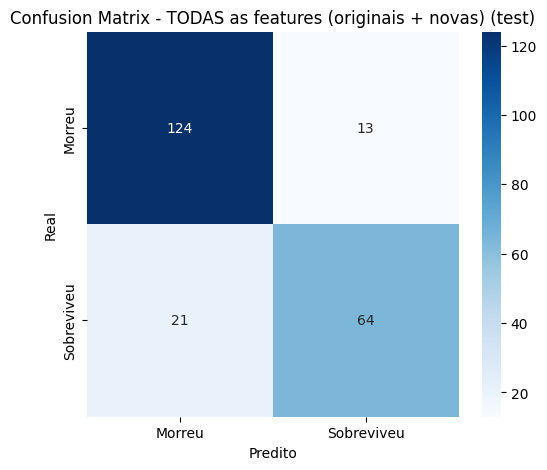


EXPERIMENTO: Apenas ORIGINAIS (sem Family, sem Age_Group)
Features usadas (12): ['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Shapes: Treino=(548, 12), Val=(224, 12), Teste=(222, 12)

Primeiras 5 linhas do conjunto de TREINO (features selecionadas):
        Age  SibSp  Parch      Fare  Embarked_C  Embarked_Q  Embarked_S  \
0  0.384236  0.000    0.0  0.014102        True       False       False   
1  0.288451  0.000    0.0  0.015412       False       False        True   
2  0.261084  0.125    0.0  0.019177       False       False        True   
3  0.165298  0.000    0.2  0.038061       False       False        True   
4  0.835796  0.000    0.0  0.020495       False       False        True   

   Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  
0       False      True     False     False      True  
1       False      True     False     False      True  
2        True     False     False     

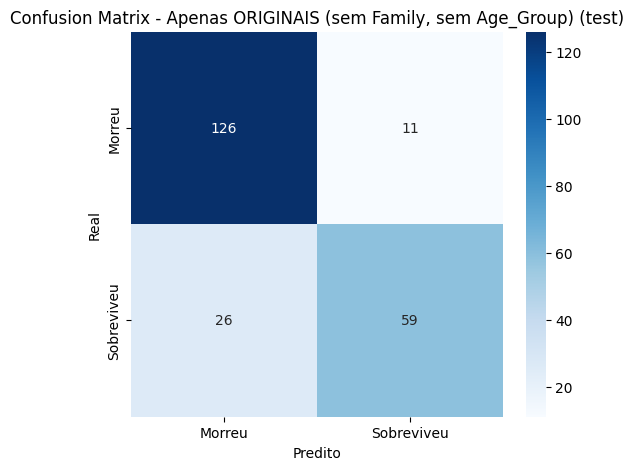


EXPERIMENTO: Apenas NOVAS (sem Age, SibSp, Parch)
Features usadas (15): ['Fare', 'Family', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_Group_0-10', 'Age_Group_10-20', 'Age_Group_20-40', 'Age_Group_40-60', 'Age_Group_60+']
Shapes: Treino=(548, 15), Val=(224, 15), Teste=(222, 15)

Primeiras 5 linhas do conjunto de TREINO (features selecionadas):
       Fare  Family  Embarked_C  Embarked_Q  Embarked_S  Sex_female  Sex_male  \
0  0.014102     0.0        True       False       False       False      True   
1  0.015412     0.0       False       False        True       False      True   
2  0.019177     0.1       False       False        True        True     False   
3  0.038061     0.1       False       False        True        True     False   
4  0.020495     0.0       False       False        True       False      True   

   Pclass_1  Pclass_2  Pclass_3  Age_Group_0-10  Age_Group_10-20  \
0     False     False      True  

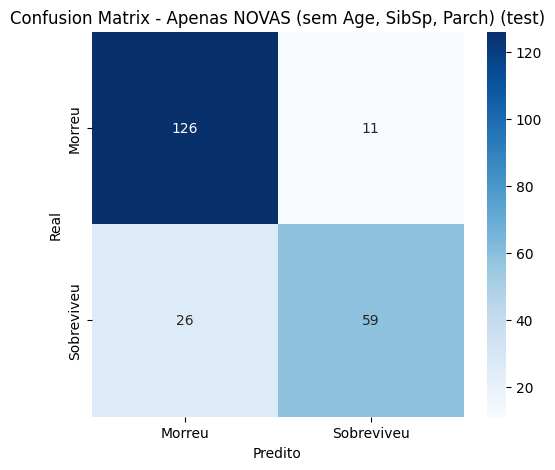

'# Resumo comparativo\nprint("\n" + "="*80)\nprint("RESUMO COMPARATIVO DOS 3 EXPERIMENTOS")\nprint("="*80)\nprint(f"\n1. TODAS as features:")\nprint(f"   Melhor F1 (val): {resultado_todas[\'f1_val\']:.4f}")\nprint(f"   Accuracy (val): {resultado_todas[\'acc_val\']:.4f}")\nprint(f"   Config: {resultado_todas[\'cfg\']}")\n\nprint(f"\n2. Apenas ORIGINAIS:")\nprint(f"   Melhor F1 (val): {resultado_originais[\'f1_val\']:.4f}")\nprint(f"   Accuracy (val): {resultado_originais[\'acc_val\']:.4f}")\nprint(f"   Config: {resultado_originais[\'cfg\']}")\n\nprint(f"\n3. Apenas NOVAS:")\nprint(f"   Melhor F1 (val): {resultado_novas[\'f1_val\']:.4f}")\nprint(f"   Accuracy (val): {resultado_novas[\'acc_val\']:.4f}")\nprint(f"   Config: {resultado_novas[\'cfg\']}")\nprint("="*80)'

In [ ]:
# ======= Ajuste de hiperparâmetros usando o conjunto de validação =======
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import time
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suprime warnings de convergência
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# 1) Separar X e y de cada conjunto (assumindo 'Survived' presente)
y_train = train_df['Survived'].reset_index(drop=True)
X_train_all = train_df.drop(columns=['Survived']).reset_index(drop=True)

y_val = val_df['Survived'].reset_index(drop=True)
X_val_all = val_df.drop(columns=['Survived']).reset_index(drop=True)

y_test = test_df['Survived'].reset_index(drop=True)
X_test_all = test_df.drop(columns=['Survived']).reset_index(drop=True)

print("Shapes (todas as features):", X_train_all.shape, X_val_all.shape, X_test_all.shape)
print("\nColunas disponíveis:", list(X_train_all.columns))

# Função para rodar grid search com diferentes conjuntos de features
def rodar_grid_search(X_train, X_val, X_test, y_train, y_val, y_test, nome_experimento, colunas_usadas):
    """
    Roda grid search de hiperparâmetros para MLPClassifier

    Args:
        X_train, X_val, X_test: conjuntos de features
        y_train, y_val, y_test: conjuntos de targets
        nome_experimento: nome descritivo do experimento
        colunas_usadas: lista de colunas usadas (para documentação)
    """
    print("\n" + "="*80)
    print(f"EXPERIMENTO: {nome_experimento}")
    print("="*80)
    print(f"Features usadas ({len(colunas_usadas)}): {colunas_usadas}")
    print(f"Shapes: Treino={X_train.shape}, Val={X_val.shape}, Teste={X_test.shape}")

    # Visualização do dataset que será usado para treinamento
    print("\nPrimeiras 5 linhas do conjunto de TREINO (features selecionadas):")
    print(X_train.head())

    # 2) Definir grade de hiperparâmetros a testar
    hidden_layer_sizes = [(50,),(100,50),(20,20)]
    activations = ['tanh', 'relu', 'logistic']
    solvers = ['adam', 'sgd', 'lbfgs']   # lbfgs funciona bem para datasets menores
    alpha_values = [1e-4, 1e-3]
    learning_rates = ['constant', 'adaptive','invscaling']  # só usados se solver=='sgd'
    learning_rates_init = [0.01,0.001,0.0001]

    configs = []
    for hidden_layer in hidden_layer_sizes:
        for act in activations:
            for sv in solvers:
                for a in alpha_values:
                    if sv != 'lbfgs':
                        for rates_init in learning_rates_init:
                            if sv == 'sgd':
                                for lr in learning_rates:
                                    configs.append({'hidden_layer_size':hidden_layer,'activation': act, 'solver': sv, 'alpha': a,  'learning_rates_init':rates_init ,'learning_rate': lr})
                            else:
                                configs.append({'hidden_layer_size':hidden_layer,'activation': act, 'solver': sv, 'alpha': a, 'learning_rates_init':rates_init})
                    else:
                        configs.append({'hidden_layer_size':hidden_layer,'activation': act, 'solver': sv, 'alpha': a})

    # 3) Loop de treino/validação para encontrar o melhor por F1 (val)
    results = []
    best_f1 = -1.0
    best_entry = None
    t0 = time.time()

    print(f"\nIniciando grid search com {len(configs)} configurações...\n")

    for i, cfg in enumerate(configs, 1):
        # criar o classificador com parâmetros apropriados
        params = {
            'hidden_layer_sizes': cfg['hidden_layer_size'],
            'random_state': 42,
            'activation': cfg['activation'],
            'solver': cfg['solver'],
            'alpha': cfg['alpha']
        }

        # Ajusta max_iter baseado no solver
        # lbfgs geralmente precisa de mais iterações
        # IMPORTANTE: Não usamos early_stopping aqui porque já temos um conjunto de validação separado (val_df)
        # que é usado APENAS para avaliar o modelo após o treinamento, não durante
        if cfg['solver'] == 'lbfgs':
            params['max_iter'] = 1000
        else:
            params['max_iter'] = 800

        # se foi definido learning_rate (apenas para sgd)
        if cfg['solver'] == 'sgd':
            params['learning_rate'] = cfg['learning_rate']
            params['learning_rate_init'] = cfg['learning_rates_init']
        if cfg['solver'] == 'adam':
            params['learning_rate_init'] = cfg['learning_rates_init']

        # constrói e treina
        try:
            clf = MLPClassifier(**params)
            t_start = time.time()
            # Treina o modelo APENAS com o conjunto de treino (X_train, y_train)
            # O conjunto de validação (X_val, y_val) NÃO é usado durante o treinamento
            clf.fit(X_train, y_train)
            t_end = time.time()

            # Verifica se convergiu (se n_iter_ < max_iter, convergiu)
            # Se n_iter_ == max_iter, pode não ter convergido
            converged = clf.n_iter_ < params['max_iter']
            converged_str = "✓" if converged else f"⚠ ({clf.n_iter_} iterações, limite: {params['max_iter']})"

            # Avalia o modelo no conjunto de validação (APÓS o treinamento)
            # Este conjunto é usado apenas para selecionar o melhor modelo, não durante o treino
            y_val_pred = clf.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            acc = accuracy_score(y_val, y_val_pred)
            duration = t_end - t_start
            results.append({'cfg': cfg, 'f1_val': f1, 'acc_val': acc, 'time_s': duration, 'model': clf, 'converged': converged})
            print(f"[{i}/{len(configs)}] {converged_str} cfg={cfg} → F1_val={f1:.4f}, acc_val={acc:.4f}, time={duration:.1f}s")

            # atualiza melhor
            if f1 > best_f1:
                best_f1 = f1
                best_entry = results[-1]
        except Exception as e:
            print(f"[{i}/{len(configs)}] ✗ Erro ao treinar: {str(e)}")
            continue

    t_total = time.time() - t0
    print("\n" + "="*70)
    print("Grid search concluído em %.1f s" % t_total)
    print("="*70)
    print(f"Melhor F1 (val): {best_f1:.4f}")
    print(f"Melhor configuração (val): {best_entry['cfg']}")
    print(f"Convergiu: {'Sim' if best_entry.get('converged', True) else 'Não'}")
    print("="*70)

    # Estatísticas de convergência
    n_converged = sum(1 for r in results if r.get('converged', True))
    n_total = len(results)
    print(f"\nEstatísticas: {n_converged}/{n_total} modelos convergiram ({100*n_converged/n_total:.1f}%)")

    # Mostra top 5 melhores modelos
    print("\nTop 5 melhores modelos (por F1 no conjunto de validação):")
    sorted_results = sorted(results, key=lambda x: x['f1_val'], reverse=True)[:5]
    for i, r in enumerate(sorted_results, 1):
        conv_str = "✓" if r.get('converged', True) else "⚠"
        print(f"{i}. {conv_str} F1={r['f1_val']:.4f}, Acc={r['acc_val']:.4f}, Time={r['time_s']:.1f}s")
        print(f"   Config: {r['cfg']}")

    # 4) Avaliar o melhor modelo no conjunto de TESTE (sem qualquer ajuste adicional)
    best_model = best_entry['model']
    y_test_pred = best_model.predict(X_test)

    print("\n----- Avaliação do MELHOR modelo (selecionado por validação) no TESTE -----")
    print(f"\nConfiguração do melhor modelo:")
    print(f"  {best_entry['cfg']}")
    print(f"\nMétricas no conjunto de TESTE:")
    print("Accuracy (test):", accuracy_score(y_test, y_test_pred))
    print("F1 (test):", f1_score(y_test, y_test_pred))
    print("\nClassification report (test):\n", classification_report(y_test, y_test_pred))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Morreu','Sobreviveu'], yticklabels=['Morreu','Sobreviveu'])
    plt.title(f'Confusion Matrix - {nome_experimento} (test)')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    return best_entry, results

# ======= Rodar 3 experimentos com diferentes conjuntos de features =======

# Identificar colunas originais e novas
colunas_originais = ['Fare', 'Age', 'SibSp', 'Parch']
colunas_novas = ['Fare', 'Family']  # Family substitui SibSp + Parch

# Identificar colunas one-hot (começam com Sex_, Embarked_, Pclass_, Age_Group_)
colunas_onehot = [col for col in X_train_all.columns if any(col.startswith(prefix) for prefix in ['Sex_', 'Embarked_', 'Pclass_', 'Age_Group_'])]

# Experimento 1: TODAS as features (originais + novas + one-hot)
print("\n" + "="*80)
print("PREPARANDO 3 EXPERIMENTOS COM DIFERENTES CONJUNTOS DE FEATURES")
print("="*80)

colunas_todas = list(X_train_all.columns)
X_train_todas = X_train_all[colunas_todas]
X_val_todas = X_val_all[colunas_todas]
X_test_todas = X_test_all[colunas_todas]

# Experimento 2: Apenas ORIGINAIS (sem Family, sem Age_Group, mas com Age, SibSp, Parch)
# INCLUI: Fare, Age, SibSp, Parch + one-hot de Sex, Embarked, Pclass
# EXCLUI: Family, Age_Group e suas colunas one-hot
colunas_originais_completo = [col for col in X_train_all.columns
                              if (col in colunas_originais) or
                              (col.startswith('Sex_') or col.startswith('Embarked_') or col.startswith('Pclass_'))]
# Garantir que Family e Age_Group não estejam incluídos
colunas_originais_completo = [col for col in colunas_originais_completo
                              if col != 'Family' and not col.startswith('Age_Group_')]

X_train_originais = X_train_all[colunas_originais_completo]
X_val_originais = X_val_all[colunas_originais_completo]
X_test_originais = X_test_all[colunas_originais_completo]

print(f"\nDEBUG - Colunas ORIGINAIS selecionadas ({len(colunas_originais_completo)}):")
print(colunas_originais_completo)

# Experimento 3: Apenas NOVAS (com Family, Age_Group, mas sem Age, SibSp, Parch)
# INCLUI: Fare, Family + one-hot de Sex, Embarked, Pclass, Age_Group
# EXCLUI: Age, SibSp, Parch
colunas_novas_completo = [col for col in X_train_all.columns
                          if (col in colunas_novas) or
                          (col.startswith('Sex_') or col.startswith('Embarked_') or col.startswith('Pclass_') or col.startswith('Age_Group_'))]
# Garantir que Age, SibSp, Parch não estejam incluídos
colunas_novas_completo = [col for col in colunas_novas_completo
                          if col not in ['Age', 'SibSp', 'Parch']]

X_train_novas = X_train_all[colunas_novas_completo]
X_val_novas = X_val_all[colunas_novas_completo]
X_test_novas = X_test_all[colunas_novas_completo]

print(f"\nDEBUG - Colunas NOVAS selecionadas ({len(colunas_novas_completo)}):")
print(colunas_novas_completo)

# Verificação: garantir que os conjuntos são diferentes
colunas_apenas_originais = set(colunas_originais_completo) - set(colunas_novas_completo)
colunas_apenas_novas = set(colunas_novas_completo) - set(colunas_originais_completo)
colunas_comuns = set(colunas_originais_completo) & set(colunas_novas_completo)

print(f"\nDEBUG - Comparação:")
print(f"  Colunas APENAS em ORIGINAIS: {sorted(colunas_apenas_originais)}")
print(f"  Colunas APENAS em NOVAS: {sorted(colunas_apenas_novas)}")
print(f"  Colunas COMUNS: {sorted(colunas_comuns)}")
print(f"  São diferentes? {len(colunas_apenas_originais) > 0 and len(colunas_apenas_novas) > 0}")
print("\n" + "="*80)

# Rodar os 3 experimentos
resultado_todas, _ = rodar_grid_search(X_train_todas, X_val_todas, X_test_todas, y_train, y_val, y_test,
                                       "TODAS as features (originais + novas)", colunas_todas)

resultado_originais, _ = rodar_grid_search(X_train_originais, X_val_originais, X_test_originais, y_train, y_val, y_test,
                                            "Apenas ORIGINAIS (sem Family, sem Age_Group)", colunas_originais_completo)

resultado_novas, _ = rodar_grid_search(X_train_novas, X_val_novas, X_test_novas, y_train, y_val, y_test,
                                        "Apenas NOVAS (sem Age, SibSp, Parch)", colunas_novas_completo)

'''# Resumo comparativo
print("\n" + "="*80)
print("RESUMO COMPARATIVO DOS 3 EXPERIMENTOS")
print("="*80)
print(f"\n1. TODAS as features:")
print(f"   Melhor F1 (val): {resultado_todas['f1_val']:.4f}")
print(f"   Accuracy (val): {resultado_todas['acc_val']:.4f}")
print(f"   Config: {resultado_todas['cfg']}")

print(f"\n2. Apenas ORIGINAIS:")
print(f"   Melhor F1 (val): {resultado_originais['f1_val']:.4f}")
print(f"   Accuracy (val): {resultado_originais['acc_val']:.4f}")
print(f"   Config: {resultado_originais['cfg']}")

print(f"\n3. Apenas NOVAS:")
print(f"   Melhor F1 (val): {resultado_novas['f1_val']:.4f}")
print(f"   Accuracy (val): {resultado_novas['acc_val']:.4f}")
print(f"   Config: {resultado_novas['cfg']}")
print("="*80)'''